In [1]:
import gym
import sys
import torch
import random
import numpy as np

import torch.nn as nn
import torch.autograd
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torch.autograd import Variable
from collections import deque

In [2]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
#         self.init_params()

    def init_params(self):
        def lim(layer):
            return 1./np.sqrt(layer.weight.data.size()[0])
        
        self.linear1.weight.data.uniform_(-lim(self.linear1),lim(self.linear1))
        self.linear2.weight.data.uniform_(-lim(self.linear2),lim(self.linear2))
        self.linear3.weight.data.uniform_(-3e-3,3e-3)
        
    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
#         self.init_params()
    
    def init_params(self):
        def lim(layer):
            return 1./np.sqrt(layer.weight.data.size()[0])
        
        self.linear1.weight.data.uniform_(-lim(self.linear1),lim(self.linear1))
        self.linear2.weight.data.uniform_(-lim(self.linear2),lim(self.linear2))
        self.linear3.weight.data.uniform_(-3e-3,3e-3)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))

        return x

In [3]:
class Buffer:
    def __init__(self, size):
        self.memory = deque(maxlen=size)
    
    def add(self, state, action, reward, next_state, done):
        step = (state, action, np.array([reward]), next_state, done)
        self.memory.append(step)
    
    def get_mini_batch(self, size):
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        
        mini_batch = random.sample(self.memory, size)
        for step in mini_batch:
            state, action, reward, next_state, done = step
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
        return states, actions, rewards, next_states, dones
    
    def get_size(self):
        return len(self.memory)
    
    def __len__(self):
        return len(self.memory)
    

In [4]:
class Agent:
    def __init__(self, env, hidden_size=256, actor_alpha=1e-4, critic_alpha=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        #environment information
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        
        #setting up parameters for neural network
        self.hidden_size = hidden_size
        self.actor_alpha = actor_alpha
        self.critic_alpha = critic_alpha
        self.gamma = gamma
        self.tau = tau
        
        #create Actor Network
        self.actor = Actor(self.num_states, self.hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, self.hidden_size, self.num_actions)
        
        self.actor_target.load_state_dict(self.actor.state_dict())
#         #copy weights for actor
#         for weight_t, weight in zip(self.actor_target.parameters(), self.actor.parameters()):
#             weight_t.data.copy_(weight.data)
        
        print(self.actor.parameters())
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_alpha)
        #create Critic Network
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        
        self.critic_target.load_state_dict(self.critic.state_dict())
#         for weight_t, weight in zip(self.critic_target.parameters(), self.critic.parameters()):
#             weight_t.data.copy_(weight.data)
        
        self.critic_criterion = nn.MSELoss()
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=actor_alpha)

        #create buffer
        self.replay_buffer = Buffer(max_memory_size)
        
    def push_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        #if buffer is full
#         if(self.buffer.get_size() > batch_size):
#             self.update(mini_batch_size)
    
        
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        #action = np.clip(action.numpy() + self.noise.get_state(), self.env.action_space.low, self.env.action_space.high)
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
        
    def update(self, mini_batch_size):
        states, actions, rewards, next_states, dones = self.replay_buffer.get_mini_batch(mini_batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        
        #update Critic
        Q = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        
        Q_t_next = self.critic_target.forward(next_states, next_actions)
        Q_targets = rewards + (self.gamma * Q_t_next)
        
        C_loss = self.critic_criterion(Q, Q_targets)
        self.critic_optim.zero_grad()
        C_loss.backward()
        self.critic_optim.step()
        
        #update Actor
        new_actions = self.actor.forward(states)
        P_loss = -self.critic.forward(states, new_actions).mean()
        self.actor_optim.zero_grad()
        P_loss.backward()
        self.actor_optim.step()
        
        #update Target network
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

    def noise_reset(self):
        self.noise.reset()
        
    def get_buffer(self):
        return self.replay_buffer

In [5]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.01, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


In [6]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [7]:
env = gym.make('BipedalWalker-v2')

In [8]:
batch_size = 128
rewards = []
avg_rewards = []
agent = Agent(env)
noise = OUNoise(env.action_space)

for episode in range(1000):
    state = env.reset()
    episode_reward = 0
    
    for step in range(700):
        action = agent.get_action(state)
        action = noise.get_action(action,step)
#         p = random.randint(10,1000)
#         if step % p == 0:
#             action = env.action_space.sample()
        env.render()
        new_state, reward, done, _ = env.step(action)
        agent.push_buffer(state, action, reward, new_state, done)
        
        if len(agent.replay_buffer) > batch_size:
            agent.update(batch_size)
        
        state = new_state
        episode_reward += reward

        if done:
            break
    
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))


<generator object Module.parameters at 0x7fe98bc59888>


/home/abhishek/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


episode: 0, reward: -107.49, average _reward: -107.49445740341466 
episode: 1, reward: -121.56, average _reward: -114.5268061630182 
episode: 2, reward: -109.21, average _reward: -112.75392976269404 
episode: 3, reward: -117.14, average _reward: -113.85056522737804 
episode: 4, reward: -134.37, average _reward: -117.95493050526815 
episode: 5, reward: -105.32, average _reward: -115.84992881210543 
episode: 6, reward: -109.53, average _reward: -114.94726133318174 
episode: 7, reward: -107.98, average _reward: -114.0761416317707 
episode: 8, reward: -105.47, average _reward: -113.11993795437527 
episode: 9, reward: -109.48, average _reward: -112.75638884434734 
episode: 10, reward: -104.49, average _reward: -112.45585162003529 
episode: 11, reward: -103.12, average _reward: -110.61155935327454 
episode: 12, reward: -120.3, average _reward: -111.7205349526151 
episode: 13, reward: -104.78, average _reward: -110.48414177295733 
episode: 14, reward: -132.62, average _reward: -110.3088611491

episode: 121, reward: -120.86, average _reward: -114.33942553398637 
episode: 122, reward: -115.91, average _reward: -114.48264575725409 
episode: 123, reward: -120.89, average _reward: -114.7242610015749 
episode: 124, reward: -110.02, average _reward: -114.70982323321213 
episode: 125, reward: -116.97, average _reward: -115.31415472473631 
episode: 126, reward: -114.52, average _reward: -115.72313134965808 
episode: 127, reward: -110.35, average _reward: -115.54382648086464 
episode: 128, reward: -113.07, average _reward: -115.50726478319612 
episode: 129, reward: -118.23, average _reward: -115.98202510833119 
episode: 130, reward: -114.36, average _reward: -115.5188601909601 
episode: 131, reward: -107.5, average _reward: -114.18285268606806 
episode: 132, reward: -117.28, average _reward: -114.319712288099 
episode: 133, reward: -119.51, average _reward: -114.18107773816728 
episode: 134, reward: -114.23, average _reward: -114.60195568451226 
episode: 135, reward: -108.73, average 

episode: 241, reward: -108.9, average _reward: -109.91256343904767 
episode: 242, reward: -105.76, average _reward: -109.21541924919306 
episode: 243, reward: -108.02, average _reward: -107.63342015924297 
episode: 244, reward: -109.88, average _reward: -107.36271199985443 
episode: 245, reward: -109.16, average _reward: -107.40774530189762 
episode: 246, reward: -104.05, average _reward: -107.3976542172887 
episode: 247, reward: -107.16, average _reward: -107.53164856504816 
episode: 248, reward: -109.76, average _reward: -107.31029709998852 
episode: 249, reward: -108.89, average _reward: -107.81797604901494 
episode: 250, reward: -119.88, average _reward: -109.14542261051795 
episode: 251, reward: -112.04, average _reward: -109.45951959444658 
episode: 252, reward: -111.56, average _reward: -110.03931465006242 
episode: 253, reward: -110.68, average _reward: -110.30582336062086 
episode: 254, reward: -108.3, average _reward: -110.14820353161147 
episode: 255, reward: -104.74, averag

episode: 361, reward: -100.02, average _reward: -91.86347629652525 
episode: 362, reward: -104.67, average _reward: -98.11766724755385 
episode: 363, reward: -47.86, average _reward: -93.11843982725705 
episode: 364, reward: -99.02, average _reward: -97.97452660006329 
episode: 365, reward: -116.98, average _reward: -99.25894297065557 
episode: 366, reward: -104.38, average _reward: -99.5604899205498 
episode: 367, reward: -105.99, average _reward: -99.39251935900002 
episode: 368, reward: -136.06, average _reward: -102.3121416547826 
episode: 369, reward: -103.39, average _reward: -102.24396369359836 
episode: 370, reward: -46.34, average _reward: -96.4695837500262 
episode: 371, reward: -103.4, average _reward: -96.80794994642869 
episode: 372, reward: -145.55, average _reward: -100.89548558492189 
episode: 373, reward: -48.28, average _reward: -100.93790162908383 
episode: 374, reward: -102.53, average _reward: -101.28931014275706 
episode: 375, reward: -45.22, average _reward: -94.

episode: 481, reward: -99.99, average _reward: -100.71281870560674 
episode: 482, reward: -104.2, average _reward: -100.93869849146209 
episode: 483, reward: -47.49, average _reward: -95.5288431235904 
episode: 484, reward: -51.54, average _reward: -90.55236273822834 
episode: 485, reward: -100.67, average _reward: -88.0969869111161 
episode: 486, reward: -103.46, average _reward: -86.34527524561823 
episode: 487, reward: -37.0, average _reward: -80.17790781441082 
episode: 488, reward: -136.44, average _reward: -81.26163573094843 
episode: 489, reward: -99.85, average _reward: -80.99696170308263 
episode: 490, reward: -104.48, average _reward: -88.51307625711209 
episode: 491, reward: -102.53, average _reward: -88.76728468215964 
episode: 492, reward: -102.48, average _reward: -88.59436116954674 
episode: 493, reward: -103.33, average _reward: -94.17896295277679 
episode: 494, reward: -119.34, average _reward: -100.95883919243057 
episode: 495, reward: -102.11, average _reward: -101.1

episode: 601, reward: -100.78, average _reward: -112.50571855390217 
episode: 602, reward: -100.0, average _reward: -111.41614798774167 
episode: 603, reward: -123.32, average _reward: -110.8803656694254 
episode: 604, reward: -97.19, average _reward: -110.25754654335333 
episode: 605, reward: -102.78, average _reward: -106.6524717464334 
episode: 606, reward: -104.01, average _reward: -106.85389211559618 
episode: 607, reward: -100.4, average _reward: -103.23541796566633 
episode: 608, reward: -103.98, average _reward: -103.57894373361879 
episode: 609, reward: -104.21, average _reward: -103.84105535436046 
episode: 610, reward: -101.81, average _reward: -103.84701020272048 
episode: 611, reward: -104.63, average _reward: -104.23216002467332 
episode: 612, reward: -105.26, average _reward: -104.75830466958568 
episode: 613, reward: -102.03, average _reward: -102.62910516040752 
episode: 614, reward: -106.16, average _reward: -103.52652214898077 
episode: 615, reward: -99.87, average _

episode: 722, reward: -100.33, average _reward: -73.384405790404 
episode: 723, reward: -107.49, average _reward: -79.76875892024209 
episode: 724, reward: -100.33, average _reward: -78.27798313145054 
episode: 725, reward: -101.76, average _reward: -85.23081894938942 
episode: 726, reward: -106.12, average _reward: -85.11648743330059 
episode: 727, reward: -101.65, average _reward: -92.92099290568432 
episode: 728, reward: -137.93, average _reward: -104.40142110684273 
episode: 729, reward: -143.79, average _reward: -107.2426624052332 
episode: 730, reward: -101.6, average _reward: -107.03653489089831 
episode: 731, reward: -102.73, average _reward: -110.3742142911473 
episode: 732, reward: -107.02, average _reward: -111.04245045084747 
episode: 733, reward: -103.33, average _reward: -110.62623843498568 
episode: 734, reward: -102.02, average _reward: -110.79479867244497 
episode: 735, reward: -102.34, average _reward: -110.85278721301907 
episode: 736, reward: -100.53, average _rewar

episode: 843, reward: -114.14, average _reward: -93.50738149847511 
episode: 844, reward: -100.39, average _reward: -90.61427361076619 
episode: 845, reward: -118.17, average _reward: -97.47873424735934 
episode: 846, reward: -103.21, average _reward: -96.54123773677989 
episode: 847, reward: -110.23, average _reward: -97.39146838593686 
episode: 848, reward: -111.24, average _reward: -97.86044585449874 
episode: 849, reward: -104.41, average _reward: -97.75134539075836 
episode: 850, reward: -109.1, average _reward: -104.6236483408928 
episode: 851, reward: -45.48, average _reward: -96.42683858308725 
episode: 852, reward: -110.66, average _reward: -102.70248549803496 
episode: 853, reward: -112.97, average _reward: -102.58589677090882 
episode: 854, reward: -108.0, average _reward: -103.34737480772078 
episode: 855, reward: -105.73, average _reward: -102.10308345027937 
episode: 856, reward: -105.33, average _reward: -102.31591208444068 
episode: 857, reward: -50.34, average _reward:

episode: 963, reward: -113.51, average _reward: -116.67689783099163 
episode: 964, reward: -114.63, average _reward: -115.79535715296122 
episode: 965, reward: -109.27, average _reward: -115.11160131430941 
episode: 966, reward: -112.9, average _reward: -114.49099791150732 
episode: 967, reward: -108.49, average _reward: -113.26938661899524 
episode: 968, reward: -116.73, average _reward: -112.76806085085522 
episode: 969, reward: -113.35, average _reward: -113.09195594604451 
episode: 970, reward: -107.67, average _reward: -112.64705575318688 
episode: 971, reward: -111.01, average _reward: -112.64459911801228 
episode: 972, reward: -106.22, average _reward: -111.37672602685345 
episode: 973, reward: -112.68, average _reward: -111.29424629685859 
episode: 974, reward: -121.72, average _reward: -112.00376066701878 
episode: 975, reward: -111.54, average _reward: -112.2311381759254 
episode: 976, reward: -113.5, average _reward: -112.29142494504802 
episode: 977, reward: -124.68, averag

In [9]:
env.close()

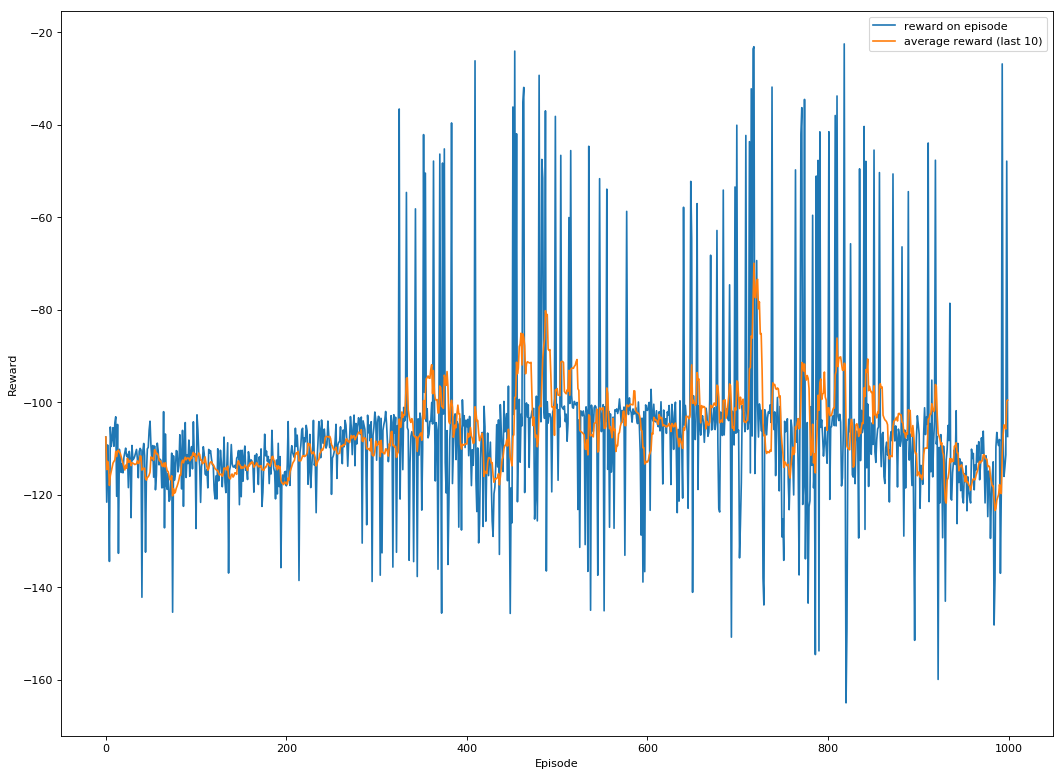

In [20]:
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["reward on episode", "average reward (last 10)"])
plt.show()

In [22]:
torch.save(agent.actor.state_dict(), './saved_model.pkl')

In [40]:
def simulation():
    saved_actor = Actor(env.observation_space.shape[0], 256, env.action_space.shape[0])
    saved_actor.load_state_dict(torch.load('./saved_model.pkl'))
#     saved_actor = agent.actor
    done = False
    state = env.reset()
    while True:
        action = saved_actor.forward(torch.tensor(state, dtype=torch.float).unsqueeze(0))
        action = action.detach().numpy()[0,0]
        env.render()
        new_state, reward, done, _ = env.step(action)
        state=new_state
        if done:
            break
    env.close()

simulation()

/home/abhishek/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


IndexError: invalid index to scalar variable.